**CNN_LSTM_Tramsformer**

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1: Train Loss: 0.0105, Val Loss: 0.0011
Epoch 2: Train Loss: 0.0043, Val Loss: 0.0000
Epoch 3: Train Loss: 0.0035, Val Loss: 0.0010
Epoch 4: Train Loss: 0.0032, Val Loss: 0.0006
Epoch 5: Train Loss: 0.0032, Val Loss: 0.0001
Epoch 6: Train Loss: 0.0032, Val Loss: 0.0000
Epoch 7: Train Loss: 0.0029, Val Loss: 0.0061
Epoch 8: Train Loss: 0.0029, Val Loss: 0.0053
Epoch 9: Train Loss: 0.0029, Val Loss: 0.0000
Epoch 10: Train Loss: 0.0028, Val Loss: 0.0000
Epoch 11: Train Loss: 0.0030, Val Loss: 0.0011
Epoch 12: Train Loss: 0.0029, Val Loss: 0.0000
Epoch 13: Train Loss: 0.0029, Val Loss: 0.0000
Epoch 14: Train Loss: 0.0026, Val Loss: 0.0000
Epoch 15: Train Loss: 0.0025, Val Loss: 0.0000
Epoch 16: Train Loss: 0.0027, Val Loss: 0.0000
Epoch 17: Train Loss: 0.0028, Val Loss: 0.0000
Epoch 18: Train Loss: 0.0026, Val Loss: 0.0000
Epoch 19: Train Loss: 0.0024, Val Loss: 0.0054
Epoch 20: Train Loss: 0.0025, Val Loss: 0.0000
Epoch 21: Train Loss: 0.0025, Val Loss: 0.0000
Epoch 22: Train Loss: 

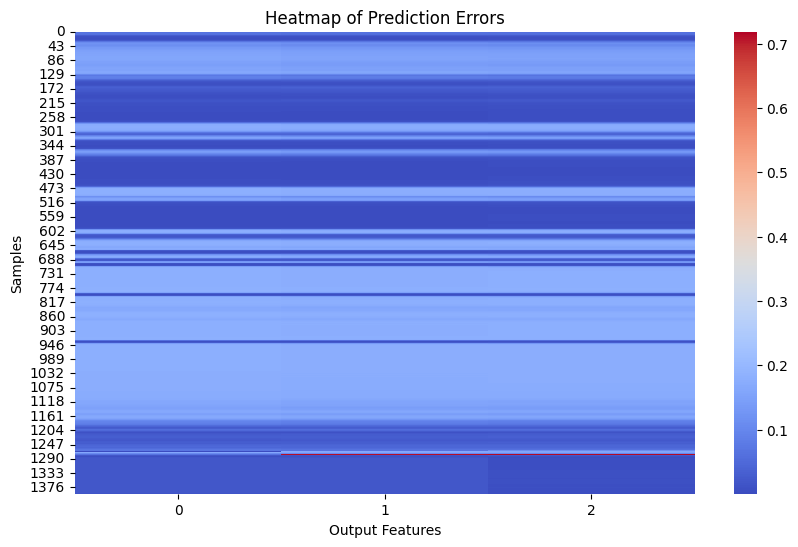

(0.094098635, 0.12185685, 1.8318459)

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load and preprocess dataset
def load_and_preprocess_data(file_path):
    df = pd.read_csv(file_path)
    
    # Drop unnecessary columns
    columns_to_drop = ['datetime(utc)', 'flycState', 'message']
    df_cleaned = df.drop(columns=[col for col in columns_to_drop if col in df.columns], errors='ignore')
    
    # Convert categorical columns to numerical values
    categorical_cols = df_cleaned.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        encoder = LabelEncoder()
        df_cleaned[col] = encoder.fit_transform(df_cleaned[col])
    
    # Convert to numeric and replace NaNs with column means
    numeric_cols = df_cleaned.select_dtypes(include=[np.number]).columns
    df_cleaned[numeric_cols] = df_cleaned[numeric_cols].apply(pd.to_numeric, errors='coerce').fillna(df_cleaned[numeric_cols].mean())
    
    # Scale data using MinMaxScaler
    scaler = MinMaxScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df_cleaned), columns=df_cleaned.columns)
    
    return df_scaled, scaler

# Dataset class
class CSIDataset(Dataset):
    def __init__(self, data, window_size=12, horizon=3):
        self.data = data.values.astype(np.float32)
        self.window_size = window_size
        self.horizon = horizon
    
    def __len__(self):
        return len(self.data) - self.window_size - self.horizon
    
    def __getitem__(self, index):
        x = self.data[index:index+self.window_size]
        y = self.data[index+self.window_size:index+self.window_size+self.horizon]
        return torch.tensor(x), torch.tensor(y)

# Optimized Model definition
class CNN_LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(CNN_LSTM, self).__init__()
        
        # CNN Feature Extraction
        self.conv1 = nn.Conv1d(in_channels=input_dim, out_channels=128, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.dropout = nn.Dropout(p=0.4)
        
        # LSTM Layer
        self.lstm = nn.LSTM(input_size=256, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True, dropout=0.4, bidirectional=True)
        
        # Fully Connected Layer with ReLU
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 2, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )
    
    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.dropout(self.pool(torch.relu(self.conv1(x))))
        x = self.dropout(self.pool(torch.relu(self.conv2(x))))
        x = x.permute(0, 2, 1)
        
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return out

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=100, patience=20):
    best_val_loss = float('inf')
    patience_counter = 0
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for x, y in train_loader:
            optimizer.zero_grad()
            output = model(x)
            y = y[:, :, -1].squeeze(dim=-1)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x_val, y_val in val_loader:
                val_output = model(x_val)
                y_val = y_val[:, :, -1].squeeze(dim=-1)
                val_loss += criterion(val_output, y_val).item()
        val_loss /= len(val_loader)
        scheduler.step(val_loss)

        print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), "best_model.pth")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered!")
                break

# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        for x, y in test_loader:
            output = model(x)
            y = y[:, :, -1].squeeze(dim=-1)
            predictions.append(output.cpu().numpy())
            actuals.append(y.cpu().numpy())
    
    predictions = np.concatenate(predictions, axis=0)
    actuals = np.concatenate(actuals, axis=0)
    
    mae = mean_absolute_error(actuals, predictions)
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    smape = np.mean(2 * np.abs(predictions - actuals) / (np.abs(predictions) + np.abs(actuals) + 1e-8))
    
    print(f"Evaluation - MAE: {mae:.4f}, RMSE: {rmse:.4f}, SMAPE: {smape:.4f}")
    
    plt.figure(figsize=(10, 6))
    sns.heatmap(np.abs(predictions - actuals), cmap='coolwarm', annot=False)
    plt.title('Heatmap of Prediction Errors')
    plt.xlabel('Output Features')
    plt.ylabel('Samples')
    plt.show()
    
    return mae, rmse, smape
# Main execution
file_path = "/kaggle/input/csi-data/CSI_Data.csv"
df_scaled, scaler = load_and_preprocess_data(file_path)
train_data, val_data, test_data = np.split(df_scaled, [int(.7*len(df_scaled)), int(.9*len(df_scaled))])

train_dataset = CSIDataset(train_data)
val_dataset = CSIDataset(val_data)
test_dataset = CSIDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model =  CNN_LSTM(input_dim=train_data.shape[1], hidden_dim=64, num_layers=2, output_dim=3)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_model(model, train_loader, val_loader, criterion, optimizer)
# Save H_test_CNN_LSTM_TF and H_hat_CNN_LSTM_TF for spectral efficiency calculation
# Save CSI Data
def save_csi_data(H_test, H_hat, file_prefix):
    with open(f"{file_prefix}_H_test.pkl", "wb") as f:
        pickle.dump(H_test, f)
    with open(f"{file_prefix}_H_hat.pkl", "wb") as f:
        pickle.dump(H_hat, f)
H_test_CNN_LSTM_TF, H_hat_CNN_LSTM_TF = [], []
model.eval()
with torch.no_grad():
    for x, y in test_loader:
        output = model(x)
        H_test_CNN_LSTM_TF.append(y.cpu().numpy())
        H_hat_CNN_LSTM_TF.append(output.cpu().numpy())

H_test_CNN_LSTM_TF = np.concatenate(H_test_CNN_LSTM_TF, axis=0)
H_hat_CNN_LSTM_TF = np.concatenate(H_hat_CNN_LSTM_TF, axis=0)

#save_csi_data(H_test_CNN_LSTM_TF, H_hat_CNN_LSTM_TF, "CSI_Data_CNN_LSTM_TF")

evaluate_model(model, test_loader)

**CNN**

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1: Train Loss: 0.0123, Val Loss: 0.0006
Epoch 2: Train Loss: 0.0056, Val Loss: 0.0025
Epoch 3: Train Loss: 0.0046, Val Loss: 0.0003
Epoch 4: Train Loss: 0.0044, Val Loss: 0.0014
Epoch 5: Train Loss: 0.0039, Val Loss: 0.0005
Epoch 6: Train Loss: 0.0039, Val Loss: 0.0013
Epoch 7: Train Loss: 0.0035, Val Loss: 0.0008
Epoch 8: Train Loss: 0.0034, Val Loss: 0.0001
Epoch 9: Train Loss: 0.0032, Val Loss: 0.0055
Epoch 10: Train Loss: 0.0032, Val Loss: 0.0003
Epoch 11: Train Loss: 0.0032, Val Loss: 0.0005
Epoch 12: Train Loss: 0.0030, Val Loss: 0.0039
Epoch 13: Train Loss: 0.0033, Val Loss: 0.0003
Epoch 14: Train Loss: 0.0031, Val Loss: 0.0043
Epoch 15: Train Loss: 0.0027, Val Loss: 0.0031
Epoch 16: Train Loss: 0.0025, Val Loss: 0.0040
Epoch 17: Train Loss: 0.0025, Val Loss: 0.0024
Epoch 18: Train Loss: 0.0027, Val Loss: 0.0017
Epoch 19: Train Loss: 0.0027, Val Loss: 0.0027
Epoch 20: Train Loss: 0.0025, Val Loss: 0.0024
Epoch 21: Train Loss: 0.0025, Val Loss: 0.0023
Epoch 22: Train Loss: 

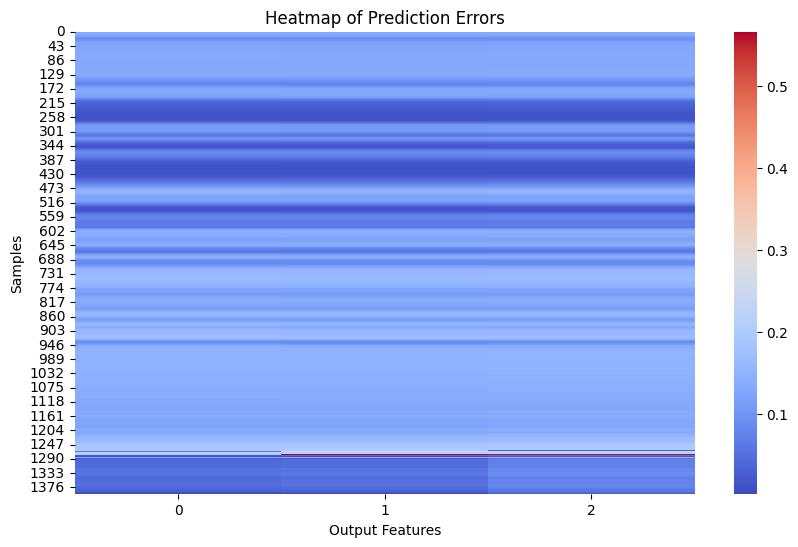

(0.10747173, 0.11851328, 1.8345579)

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import pickle

# CNN Model Definition
class CNN_Model(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(CNN_Model, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_dim, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.dropout = nn.Dropout(p=0.3)
        self.fc = nn.Linear(128, output_dim)
    
    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.dropout(self.pool(torch.relu(self.conv1(x))))
        x = self.dropout(self.pool(torch.relu(self.conv2(x))))
        x = x.mean(dim=2)  # Global Average Pooling
        out = self.fc(x)
        return out

# Training Function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=100, patience=20):
    best_val_loss = float('inf')
    patience_counter = 0
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for x, y in train_loader:
            optimizer.zero_grad()
            output = model(x)
            y = y[:, :, -1].squeeze(dim=-1)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x_val, y_val in val_loader:
                val_output = model(x_val)
                y_val = y_val[:, :, -1].squeeze(dim=-1)
                val_loss += criterion(val_output, y_val).item()
        val_loss /= len(val_loader)
        scheduler.step(val_loss)

        print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), "best_cnn_model.pth")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered!")
                break

# Save CSI Data
def save_csi_data(H_test, H_hat, file_prefix):
    with open(f"{file_prefix}_H_test.pkl", "wb") as f:
        pickle.dump(H_test, f)
    with open(f"{file_prefix}_H_hat.pkl", "wb") as f:
        pickle.dump(H_hat, f)

# Main Execution
model = CNN_Model(input_dim=train_data.shape[1], output_dim=3)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_model(model, train_loader, val_loader, criterion, optimizer)

# Save H_test_CNN and H_hat_CNN for spectral efficiency calculation
H_test_CNN, H_hat_CNN = [], []
model.eval()
with torch.no_grad():
    for x, y in test_loader:
        output = model(x)
        H_test_CNN.append(y.cpu().numpy())
        H_hat_CNN.append(output.cpu().numpy())

H_test_CNN = np.concatenate(H_test_CNN, axis=0)
H_hat_CNN = np.concatenate(H_hat_CNN, axis=0)

#save_csi_data(H_test_CNN, H_hat_CNN, "CSI_Data_CNN")

evaluate_model(model, test_loader)


**LSTM**

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1: Train Loss: 0.0101, Val Loss: 0.0005
Epoch 2: Train Loss: 0.0047, Val Loss: 0.0007
Epoch 3: Train Loss: 0.0035, Val Loss: 0.0004
Epoch 4: Train Loss: 0.0030, Val Loss: 0.0003
Epoch 5: Train Loss: 0.0029, Val Loss: 0.0013
Epoch 6: Train Loss: 0.0026, Val Loss: 0.0003
Epoch 7: Train Loss: 0.0025, Val Loss: 0.0004
Epoch 8: Train Loss: 0.0024, Val Loss: 0.0000
Epoch 9: Train Loss: 0.0024, Val Loss: 0.0001
Epoch 10: Train Loss: 0.0024, Val Loss: 0.0000
Epoch 11: Train Loss: 0.0022, Val Loss: 0.0001
Epoch 12: Train Loss: 0.0022, Val Loss: 0.0001
Epoch 13: Train Loss: 0.0023, Val Loss: 0.0003
Epoch 14: Train Loss: 0.0040, Val Loss: 0.0017
Epoch 15: Train Loss: 0.0021, Val Loss: 0.0016
Epoch 16: Train Loss: 0.0018, Val Loss: 0.0000
Epoch 17: Train Loss: 0.0019, Val Loss: 0.0000
Epoch 18: Train Loss: 0.0018, Val Loss: 0.0000
Epoch 19: Train Loss: 0.0017, Val Loss: 0.0001
Epoch 20: Train Loss: 0.0017, Val Loss: 0.0000
Epoch 21: Train Loss: 0.0017, Val Loss: 0.0000
Epoch 22: Train Loss: 

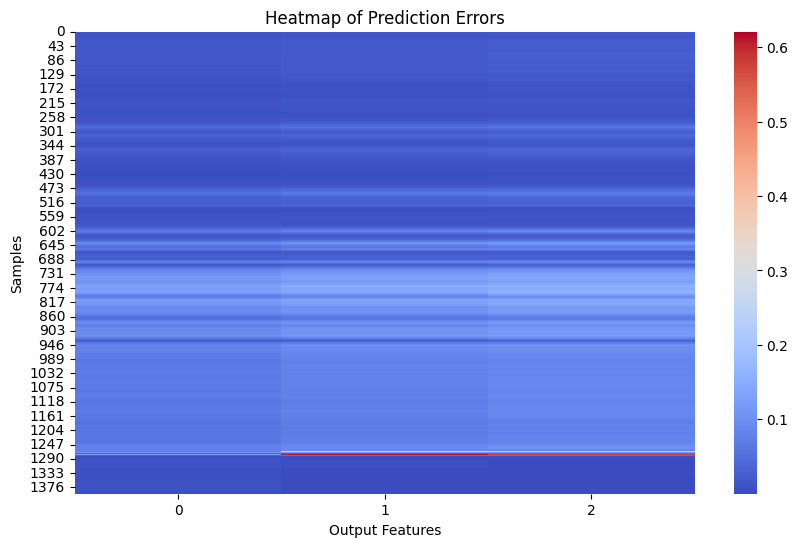

(0.048816342, 0.066466786, 1.8297517)

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import pickle

# LSTM Model Definition
class LSTM_Model(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM_Model, self).__init__()
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True, dropout=0.3)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return out

# Training Function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=100, patience=20):
    best_val_loss = float('inf')
    patience_counter = 0
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for x, y in train_loader:
            optimizer.zero_grad()
            output = model(x)
            y = y[:, :, -1].squeeze(dim=-1)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x_val, y_val in val_loader:
                val_output = model(x_val)
                y_val = y_val[:, :, -1].squeeze(dim=-1)
                val_loss += criterion(val_output, y_val).item()
        val_loss /= len(val_loader)
        scheduler.step(val_loss)

        print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), "best_lstm_model.pth")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered!")
                break

# Save CSI Data
def save_csi_data(H_test, H_hat, file_prefix):
    with open(f"{file_prefix}_H_test.pkl", "wb") as f:
        pickle.dump(H_test, f)
    with open(f"{file_prefix}_H_hat.pkl", "wb") as f:
        pickle.dump(H_hat, f)

# Main Execution
model = LSTM_Model(input_dim=train_data.shape[1], hidden_dim=64, num_layers=2, output_dim=3)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_model(model, train_loader, val_loader, criterion, optimizer)

# Save H_test_LSTM and H_hat_LSTM for spectral efficiency calculation
H_test_LSTM, H_hat_LSTM = [], []
model.eval()
with torch.no_grad():
    for x, y in test_loader:
        output = model(x)
        H_test_LSTM.append(y.cpu().numpy())
        H_hat_LSTM.append(output.cpu().numpy())

H_test_LSTM = np.concatenate(H_test_LSTM, axis=0)
H_hat_LSTM = np.concatenate(H_hat_LSTM, axis=0)

#save_csi_data(H_test_LSTM, H_hat_LSTM, "CSI_Data_LSTM")

evaluate_model(model, test_loader)


**CNN+LSTM**

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1: Train Loss: 0.0096, Val Loss: 0.0013
Epoch 2: Train Loss: 0.0033, Val Loss: 0.0000
Epoch 3: Train Loss: 0.0030, Val Loss: 0.0002
Epoch 4: Train Loss: 0.0028, Val Loss: 0.0001
Epoch 5: Train Loss: 0.0039, Val Loss: 0.0001
Epoch 6: Train Loss: 0.0027, Val Loss: 0.0000
Epoch 7: Train Loss: 0.0032, Val Loss: 0.0003
Epoch 8: Train Loss: 0.0026, Val Loss: 0.0000
Epoch 9: Train Loss: 0.0023, Val Loss: 0.0000
Epoch 10: Train Loss: 0.0023, Val Loss: 0.0027
Epoch 11: Train Loss: 0.0021, Val Loss: 0.0001
Epoch 12: Train Loss: 0.0020, Val Loss: 0.0017
Epoch 13: Train Loss: 0.0020, Val Loss: 0.0016
Epoch 14: Train Loss: 0.0019, Val Loss: 0.0000
Epoch 15: Train Loss: 0.0022, Val Loss: 0.0000
Epoch 16: Train Loss: 0.0019, Val Loss: 0.0006
Epoch 17: Train Loss: 0.0017, Val Loss: 0.0023
Epoch 18: Train Loss: 0.0019, Val Loss: 0.0008
Epoch 19: Train Loss: 0.0018, Val Loss: 0.0001
Epoch 20: Train Loss: 0.0019, Val Loss: 0.0003
Epoch 21: Train Loss: 0.0019, Val Loss: 0.0000
Epoch 22: Train Loss: 

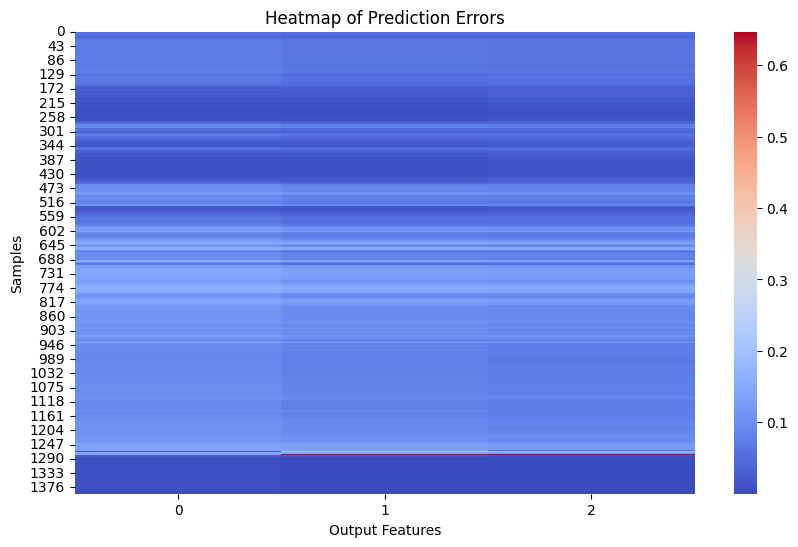

(0.07041042, 0.0846926, 1.8294387)

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pickle

# Load and preprocess data
def load_and_preprocess_data(file_path):
    df = pd.read_csv(file_path)
    
    # Drop unnecessary columns
    columns_to_drop = ['datetime(utc)', 'flycState', 'message']
    df_cleaned = df.drop(columns=[col for col in columns_to_drop if col in df.columns], errors='ignore')
    
    # Convert categorical columns to numerical values
    categorical_cols = df_cleaned.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        encoder = LabelEncoder()
        df_cleaned[col] = encoder.fit_transform(df_cleaned[col])
    
    # Convert to numeric and replace NaNs with column means
    numeric_cols = df_cleaned.select_dtypes(include=[np.number]).columns
    df_cleaned[numeric_cols] = df_cleaned[numeric_cols].apply(pd.to_numeric, errors='coerce').fillna(df_cleaned[numeric_cols].mean())
    
    # Scale data using MinMaxScaler
    scaler = MinMaxScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df_cleaned), columns=df_cleaned.columns)
    
    return df_scaled, scaler

# Dataset class
class CSIDataset(Dataset):
    def __init__(self, data, window_size=12, horizon=3):
        self.data = data.values.astype(np.float32)
        self.window_size = window_size
        self.horizon = horizon
    
    def __len__(self):
        return len(self.data) - self.window_size - self.horizon
    
    def __getitem__(self, index):
        x = self.data[index:index+self.window_size]
        y = self.data[index+self.window_size:index+self.window_size+self.horizon]
        return torch.tensor(x), torch.tensor(y)

# CNN + LSTM Model
class CNNLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(CNNLSTM, self).__init__()
        
        self.conv1 = nn.Conv1d(in_channels=input_dim, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        
        self.lstm = nn.LSTM(input_size=128, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True, dropout=0.3, bidirectional=True)
        
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 2, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )
    
    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.permute(0, 2, 1)
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return out

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=100, patience=20):
    best_val_loss = float('inf')
    patience_counter = 0
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for x, y in train_loader:
            optimizer.zero_grad()
            output = model(x)
            y_target = y[:, :, -1].squeeze(dim=-1)
            loss = criterion(output, y_target)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x_val, y_val in val_loader:
                val_output = model(x_val)
                y_val_target = y_val[:, :, -1].squeeze(dim=-1)
                val_loss += criterion(val_output, y_val_target).item()
        val_loss /= len(val_loader)
        scheduler.step(val_loss)

        print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), "cnn_lstm.pth")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered!")
                break

# Main execution
file_path = "/kaggle/input/csi-data/CSI_Data.csv"
df_scaled, scaler = load_and_preprocess_data(file_path)
train_data, val_data, test_data = np.split(df_scaled, [int(.7*len(df_scaled)), int(.9*len(df_scaled))])

train_dataset = CSIDataset(train_data)
val_dataset = CSIDataset(val_data)
test_dataset = CSIDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize and train the CNN-LSTM model
model = CNNLSTM(input_dim=train_data.shape[1], hidden_dim=128, num_layers=3, output_dim=3)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

train_model(model, train_loader, val_loader, criterion, optimizer)

# Save H_test_RNN and H_hat_RNN for spectral efficiency calculation
H_test_CNN_LSTM, H_hat_CNN_LSTM = [], []
model.eval()
with torch.no_grad():
    for x, y in test_loader:
        output = model(x)
        H_test_CNN_LSTM.append(y.cpu().numpy())
        H_hat_CNN_LSTM.append(output.cpu().numpy())

H_test_CNN_LSTM = np.concatenate(H_test_CNN_LSTM, axis=0)
H_hat_CNN_LSTM = np.concatenate(H_hat_CNN_LSTM, axis=0)

# Optionally save the CSI data for further analysis
# def save_csi_data(H_test, H_hat, file_prefix):
#     with open(f"{file_prefix}_H_test.pkl", "wb") as f:
#         pickle.dump(H_test, f)
#     with open(f"{file_prefix}_H_hat.pkl", "wb") as f:
#         pickle.dump(H_hat, f)
# save_csi_data(H_test_RNN, H_hat_RNN, "CSI_Data_RNN")

evaluate_model(model, test_loader)

**RNN**

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1: Train Loss: 0.0106, Val Loss: 0.0001
Epoch 2: Train Loss: 0.0040, Val Loss: 0.0002
Epoch 3: Train Loss: 0.0035, Val Loss: 0.0000
Epoch 4: Train Loss: 0.0032, Val Loss: 0.0000
Epoch 5: Train Loss: 0.0032, Val Loss: 0.0000
Epoch 6: Train Loss: 0.0029, Val Loss: 0.0000
Epoch 7: Train Loss: 0.0030, Val Loss: 0.0000
Epoch 8: Train Loss: 0.0028, Val Loss: 0.0000
Epoch 9: Train Loss: 0.0027, Val Loss: 0.0001
Epoch 10: Train Loss: 0.0024, Val Loss: 0.0000
Epoch 11: Train Loss: 0.0023, Val Loss: 0.0000
Epoch 12: Train Loss: 0.0023, Val Loss: 0.0000
Epoch 13: Train Loss: 0.0022, Val Loss: 0.0000
Epoch 14: Train Loss: 0.0022, Val Loss: 0.0002
Epoch 15: Train Loss: 0.0022, Val Loss: 0.0000
Epoch 16: Train Loss: 0.0021, Val Loss: 0.0000
Epoch 17: Train Loss: 0.0021, Val Loss: 0.0000
Epoch 18: Train Loss: 0.0020, Val Loss: 0.0000
Epoch 19: Train Loss: 0.0018, Val Loss: 0.0005
Epoch 20: Train Loss: 0.0018, Val Loss: 0.0000
Epoch 21: Train Loss: 0.0017, Val Loss: 0.0002
Epoch 22: Train Loss: 

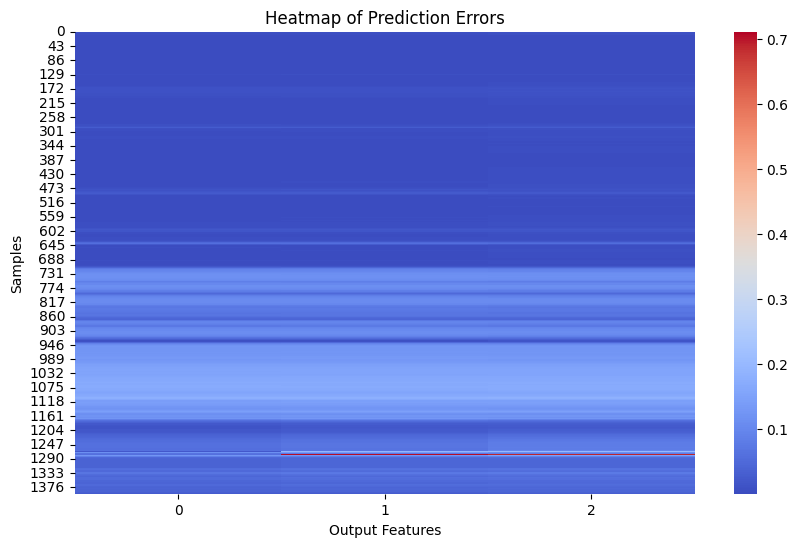

(0.048789605, 0.07755748, 1.8352833)

In [5]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pickle

# Load and preprocess dataset
def load_and_preprocess_data(file_path):
    df = pd.read_csv(file_path)
    
    # Drop unnecessary columns
    columns_to_drop = ['datetime(utc)', 'flycState', 'message']
    df_cleaned = df.drop(columns=[col for col in columns_to_drop if col in df.columns], errors='ignore')
    
    # Convert categorical columns to numerical values
    categorical_cols = df_cleaned.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        encoder = LabelEncoder()
        df_cleaned[col] = encoder.fit_transform(df_cleaned[col])
    
    # Convert to numeric and replace NaNs with column means
    numeric_cols = df_cleaned.select_dtypes(include=[np.number]).columns
    df_cleaned[numeric_cols] = df_cleaned[numeric_cols].apply(pd.to_numeric, errors='coerce').fillna(df_cleaned[numeric_cols].mean())
    
    # Scale data using MinMaxScaler
    scaler = MinMaxScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df_cleaned), columns=df_cleaned.columns)
    
    return df_scaled, scaler

# Dataset class
class CSIDataset(Dataset):
    def __init__(self, data, window_size=12, horizon=3):
        self.data = data.values.astype(np.float32)
        self.window_size = window_size
        self.horizon = horizon
    
    def __len__(self):
        return len(self.data) - self.window_size - self.horizon
    
    def __getitem__(self, index):
        x = self.data[index:index+self.window_size]
        y = self.data[index+self.window_size:index+self.window_size+self.horizon]
        return torch.tensor(x), torch.tensor(y)

# RNN Model definition
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(RNNModel, self).__init__()
        # RNN layer with ReLU activation. Note that dropout is applied for num_layers > 1.
        self.rnn = nn.RNN(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            nonlinearity='relu',
            batch_first=True,
            dropout=0.3 if num_layers > 1 else 0
        )
        # Fully connected layer for regression
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # x shape: (batch, window_size, input_dim)
        rnn_out, _ = self.rnn(x)
        # Use the hidden state of the last time step
        out = self.fc(rnn_out[:, -1, :])
        return out

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=100, patience=20):
    best_val_loss = float('inf')
    patience_counter = 0
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for x, y in train_loader:
            optimizer.zero_grad()
            output = model(x)
            # Using the last feature in the horizon as the target
            y_target = y[:, :, -1].squeeze(dim=-1)
            loss = criterion(output, y_target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x_val, y_val in val_loader:
                val_output = model(x_val)
                y_val_target = y_val[:, :, -1].squeeze(dim=-1)
                val_loss += criterion(val_output, y_val_target).item()
        val_loss /= len(val_loader)
        scheduler.step(val_loss)

        print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), "best_model_rnn.pth")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered!")
                break

# Heatmap function
def plot_heatmap(actuals, predictions):
    error_matrix = np.abs(predictions - actuals)
    plt.figure(figsize=(10, 6))
    sns.heatmap(error_matrix, cmap='coolwarm', annot=False)
    plt.title('Heatmap of Prediction Errors')
    plt.xlabel('Output Features')
    plt.ylabel('Samples')
    plt.show()

# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        for x, y in test_loader:
            output = model(x)
            y_target = y[:, :, -1].squeeze(dim=-1)
            predictions.append(output.cpu().numpy())
            actuals.append(y_target.cpu().numpy())
    
    predictions = np.concatenate(predictions, axis=0)
    actuals = np.concatenate(actuals, axis=0)
    
    mae = mean_absolute_error(actuals, predictions)
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    smape = np.mean(2 * np.abs(predictions - actuals) / (np.abs(predictions) + np.abs(actuals) + 1e-8))
    
    print(f"Evaluation - MAE: {mae:.4f}, RMSE: {rmse:.4f}, SMAPE: {smape:.4f}")
    plot_heatmap(actuals, predictions)
    
    return mae, rmse, smape

# Main execution
file_path = "/kaggle/input/csi-data/CSI_Data.csv"
df_scaled, scaler = load_and_preprocess_data(file_path)
train_data, val_data, test_data = np.split(df_scaled, [int(.7*len(df_scaled)), int(.9*len(df_scaled))])

train_dataset = CSIDataset(train_data)
val_dataset = CSIDataset(val_data)
test_dataset = CSIDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize and train the RNN model
model = RNNModel(input_dim=train_data.shape[1], hidden_dim=64, num_layers=2, output_dim=3)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_model(model, train_loader, val_loader, criterion, optimizer)

# Save H_test_RNN and H_hat_RNN for spectral efficiency calculation
H_test_RNN, H_hat_RNN = [], []
model.eval()
with torch.no_grad():
    for x, y in test_loader:
        output = model(x)
        H_test_RNN.append(y.cpu().numpy())
        H_hat_RNN.append(output.cpu().numpy())

H_test_RNN = np.concatenate(H_test_RNN, axis=0)
H_hat_RNN = np.concatenate(H_hat_RNN, axis=0)

# Optionally save the CSI data for further analysis
# def save_csi_data(H_test, H_hat, file_prefix):
#     with open(f"{file_prefix}_H_test.pkl", "wb") as f:
#         pickle.dump(H_test, f)
#     with open(f"{file_prefix}_H_hat.pkl", "wb") as f:
#         pickle.dump(H_hat, f)
# save_csi_data(H_test_RNN, H_hat_RNN, "CSI_Data_RNN")

evaluate_model(model, test_loader)


**Transformer**

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1: Train Loss: 0.0331, Val Loss: 0.0006
Epoch 2: Train Loss: 0.0047, Val Loss: 0.0003
Epoch 3: Train Loss: 0.0036, Val Loss: 0.0001
Epoch 4: Train Loss: 0.0034, Val Loss: 0.0003
Epoch 5: Train Loss: 0.0030, Val Loss: 0.0004
Epoch 6: Train Loss: 0.0030, Val Loss: 0.0001
Epoch 7: Train Loss: 0.0031, Val Loss: 0.0001
Epoch 8: Train Loss: 0.0028, Val Loss: 0.0001
Epoch 9: Train Loss: 0.0025, Val Loss: 0.0001
Epoch 10: Train Loss: 0.0023, Val Loss: 0.0003
Epoch 11: Train Loss: 0.0023, Val Loss: 0.0001
Epoch 12: Train Loss: 0.0023, Val Loss: 0.0000
Epoch 13: Train Loss: 0.0026, Val Loss: 0.0018
Epoch 14: Train Loss: 0.0062, Val Loss: 0.0004
Epoch 15: Train Loss: 0.0044, Val Loss: 0.0004
Epoch 16: Train Loss: 0.0029, Val Loss: 0.0000
Epoch 17: Train Loss: 0.0033, Val Loss: 0.0001
Epoch 18: Train Loss: 0.0025, Val Loss: 0.0001
Epoch 19: Train Loss: 0.0022, Val Loss: 0.0000
Epoch 20: Train Loss: 0.0024, Val Loss: 0.0001
Epoch 21: Train Loss: 0.0023, Val Loss: 0.0000
Epoch 22: Train Loss: 

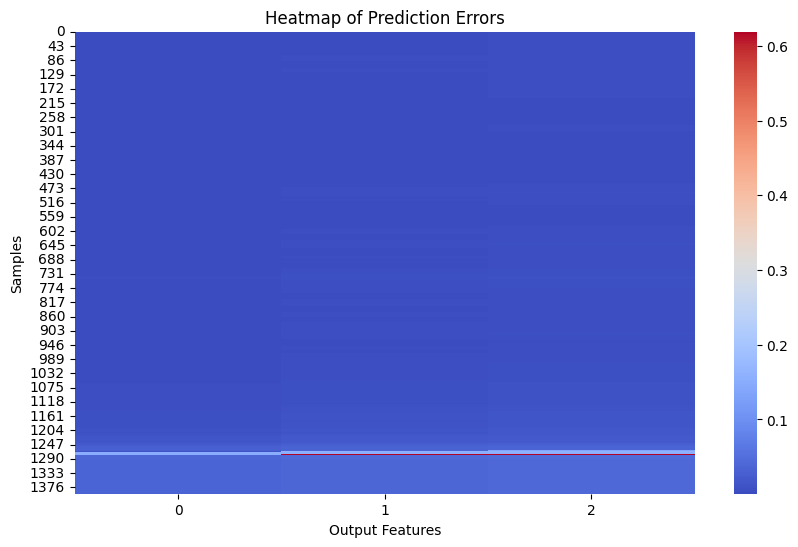

(0.0089000575, 0.029636381, 1.8342346)

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pickle

# Load and preprocess dataset
def load_and_preprocess_data(file_path):
    df = pd.read_csv(file_path)
    
    # Drop unnecessary columns
    columns_to_drop = ['datetime(utc)', 'flycState', 'message']
    df_cleaned = df.drop(columns=[col for col in columns_to_drop if col in df.columns], errors='ignore')
    
    # Convert categorical columns to numerical values
    categorical_cols = df_cleaned.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        encoder = LabelEncoder()
        df_cleaned[col] = encoder.fit_transform(df_cleaned[col])
    
    # Convert to numeric and replace NaNs with column means
    numeric_cols = df_cleaned.select_dtypes(include=[np.number]).columns
    df_cleaned[numeric_cols] = df_cleaned[numeric_cols].apply(pd.to_numeric, errors='coerce').fillna(df_cleaned[numeric_cols].mean())
    
    # Scale data using MinMaxScaler
    scaler = MinMaxScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df_cleaned), columns=df_cleaned.columns)
    
    return df_scaled, scaler

# Dataset class
class CSIDataset(Dataset):
    def __init__(self, data, window_size=12, horizon=3):
        self.data = data.values.astype(np.float32)
        self.window_size = window_size
        self.horizon = horizon
    
    def __len__(self):
        return len(self.data) - self.window_size - self.horizon
    
    def __getitem__(self, index):
        x = self.data[index:index+self.window_size]
        y = self.data[index+self.window_size:index+self.window_size+self.horizon]
        return torch.tensor(x), torch.tensor(y)

# Transformer Model definition
class TransformerModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(TransformerModel, self).__init__()
        # Project input features to the model dimension
        self.embedding = nn.Linear(input_dim, hidden_dim)
        self.dropout = nn.Dropout(p=0.3)
        # Define the Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=4, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        # Final linear layer for regression
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # x shape: (batch, window_size, input_dim)
        x = self.embedding(x)
        x = self.dropout(x)
        x = self.transformer(x)
        # Use the representation of the last time step for prediction
        out = self.fc(x[:, -1, :])
        return out

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=100, patience=20):
    best_val_loss = float('inf')
    patience_counter = 0
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for x, y in train_loader:
            optimizer.zero_grad()
            output = model(x)
            # Use the last feature in the horizon as the target
            y_target = y[:, :, -1].squeeze(dim=-1)
            loss = criterion(output, y_target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x_val, y_val in val_loader:
                val_output = model(x_val)
                y_val_target = y_val[:, :, -1].squeeze(dim=-1)
                val_loss += criterion(val_output, y_val_target).item()
        val_loss /= len(val_loader)
        scheduler.step(val_loss)

        print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), "best_model_transformer.pth")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered!")
                break

# Heatmap function for visualization
def plot_heatmap(actuals, predictions):
    error_matrix = np.abs(predictions - actuals)
    plt.figure(figsize=(10, 6))
    sns.heatmap(error_matrix, cmap='coolwarm', annot=False)
    plt.title('Heatmap of Prediction Errors')
    plt.xlabel('Output Features')
    plt.ylabel('Samples')
    plt.show()

# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        for x, y in test_loader:
            output = model(x)
            y_target = y[:, :, -1].squeeze(dim=-1)
            predictions.append(output.cpu().numpy())
            actuals.append(y_target.cpu().numpy())
    
    predictions = np.concatenate(predictions, axis=0)
    actuals = np.concatenate(actuals, axis=0)
    
    mae = mean_absolute_error(actuals, predictions)
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    smape = np.mean(2 * np.abs(predictions - actuals) / (np.abs(predictions) + np.abs(actuals) + 1e-8))
    
    print(f"Evaluation - MAE: {mae:.4f}, RMSE: {rmse:.4f}, SMAPE: {smape:.4f}")
    
    plot_heatmap(actuals, predictions)
    
    return mae, rmse, smape

# Main execution
file_path = "/kaggle/input/csi-data/CSI_Data.csv"
df_scaled, scaler = load_and_preprocess_data(file_path)
train_data, val_data, test_data = np.split(df_scaled, [int(.7*len(df_scaled)), int(.9*len(df_scaled))])

train_dataset = CSIDataset(train_data)
val_dataset = CSIDataset(val_data)
test_dataset = CSIDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize and train the Transformer model
model = TransformerModel(input_dim=train_data.shape[1], hidden_dim=64, num_layers=2, output_dim=3)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_model(model, train_loader, val_loader, criterion, optimizer)

# Save H_test_Transformer and H_hat_Transformer for spectral efficiency calculation
H_test_Transformer, H_hat_Transformer = [], []
model.eval()
with torch.no_grad():
    for x, y in test_loader:
        output = model(x)
        H_test_Transformer.append(y.cpu().numpy())
        H_hat_Transformer.append(output.cpu().numpy())

H_test_Transformer = np.concatenate(H_test_Transformer, axis=0)
H_hat_Transformer = np.concatenate(H_hat_Transformer, axis=0)

# Optionally save the CSI data for further analysis
# def save_csi_data(H_test, H_hat, file_prefix):
#     with open(f"{file_prefix}_H_test.pkl", "wb") as f:
#         pickle.dump(H_test, f)
#     with open(f"{file_prefix}_H_hat.pkl", "wb") as f:
#         pickle.dump(H_hat, f)
# save_csi_data(H_test_Transformer, H_hat_Transformer, "CSI_Data_Transformer")

evaluate_model(model, test_loader)


**Sprectral Efficiency**

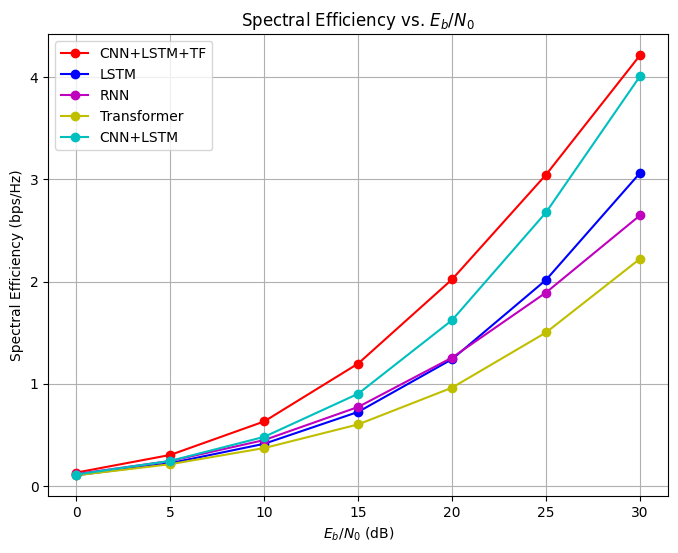

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# --- Update these based on your MIMO system dimensions ---
N_r = 2  # Example: number of receive antennas
N_t = 2  # Example: number of transmit antennas
# --------------------------------------------------------


def prepare_channel_matrix(H, N_r, N_t):
    if H.ndim == 1:
        total_elements = H.size
        num_samples = total_elements // (N_r * N_t)
        if total_elements != num_samples * N_r * N_t:
            raise ValueError("Total number of elements does not match (num_samples, N_r, N_t).")
        return H.reshape(num_samples, N_r, N_t)
    elif H.ndim == 2:
        if H.shape[1] == N_r * N_t:
            return H.reshape(H.shape[0], N_r, N_t)
        elif H.shape[0] == N_r and H.shape[1] == N_t:
            return H[np.newaxis, :, :]
        else:
            total_elements = H.size
            if total_elements % (N_r * N_t) == 0:
                return H.reshape(-1, N_r, N_t)
            else:
                raise ValueError(f"For a 2D array, expected shape (num_samples, {N_r*N_t}) or ({N_r}, {N_t}). Got shape {H.shape}.")
    elif H.ndim == 3:
        return H
    else:
        raise ValueError("H must be a 1D, 2D, or 3D array.")

H_test_CNN_LSTM_TF = prepare_channel_matrix(H_test_CNN_LSTM_TF, N_r, N_t)
H_hat_CNN_LSTM_TF  = prepare_channel_matrix(H_hat_CNN_LSTM_TF,  N_r, N_t)
H_test_CNN         = prepare_channel_matrix(H_test_CNN,         N_r, N_t)
H_hat_CNN          = prepare_channel_matrix(H_hat_CNN,          N_r, N_t)
H_test_LSTM        = prepare_channel_matrix(H_test_LSTM,        N_r, N_t)
H_hat_LSTM         = prepare_channel_matrix(H_hat_LSTM,         N_r, N_t)
H_test_RNN         = prepare_channel_matrix(H_test_RNN,         N_r, N_t)
H_hat_RNN          = prepare_channel_matrix(H_hat_RNN,          N_r, N_t)
H_test_Transformer = prepare_channel_matrix(H_test_Transformer, N_r, N_t)
H_hat_Transformer  = prepare_channel_matrix(H_hat_Transformer,  N_r, N_t)
H_test_CNN_LSTM    = prepare_channel_matrix(H_test_CNN_LSTM,    N_r, N_t)
H_hat_CNN_LSTM     = prepare_channel_matrix(H_hat_CNN_LSTM,     N_r, N_t)

def compute_spectral_efficiency(H, snr_dB):
    num_samples, N_r, N_t = H.shape
    snr_linear = 10.0 ** (snr_dB / 10.0)  
    capacity = 0.0
    for i in range(num_samples):
        H_i = H[i]  
        R = np.eye(N_r) + (snr_linear / N_t) * (H_i @ H_i.conj().T)
        capacity += np.log2(np.linalg.det(R))
    return capacity / num_samples

def compute_capacity_curve(H, snr_list_dB):
    capacities = []
    for snr in snr_list_dB:
        c = compute_spectral_efficiency(H, snr)
        capacities.append(c)
    return np.array(capacities)

snr_list_dB = np.arange(0, 35, 5)

C_true_CNN_LSTM_TF = compute_capacity_curve(H_test_CNN_LSTM_TF, snr_list_dB)
C_est_CNN_LSTM_TF  = compute_capacity_curve(H_hat_CNN_LSTM_TF,  snr_list_dB)
C_est_CNN          = compute_capacity_curve(H_hat_CNN,         snr_list_dB)
C_est_LSTM         = compute_capacity_curve(H_hat_LSTM,        snr_list_dB)
C_est_RNN          = compute_capacity_curve(H_hat_RNN,         snr_list_dB)
C_est_Transformer  = compute_capacity_curve(H_hat_Transformer, snr_list_dB)
C_est_CNN_LSTM     = compute_capacity_curve(H_hat_CNN_LSTM   , snr_list_dB)

plt.figure(figsize=(8, 6))
plt.plot(snr_list_dB, C_est_CNN_LSTM_TF, 'r-o', label='CNN+LSTM+TF')
#plt.plot(snr_list_dB, C_est_CNN,         'g-o', label='CNN')
plt.plot(snr_list_dB, C_est_LSTM,        'b-o', label='LSTM')
plt.plot(snr_list_dB, C_est_RNN,         'm-o', label='RNN')
plt.plot(snr_list_dB, C_est_Transformer, 'y-o', label='Transformer')
plt.plot(snr_list_dB, C_est_CNN_LSTM,    'c-o', label='CNN+LSTM')

plt.xlabel('$E_b/N_0$ (dB)')
plt.ylabel('Spectral Efficiency (bps/Hz)')
plt.title('Spectral Efficiency vs. $E_b/N_0$')
plt.grid(True)
plt.legend()
plt.show()
